# Project: Study of Electrodes' Ability, Attached to Tissue to Distinct Nonlinear Behaviour of the Cell

> Course: Bioelectrical Phenomena

> Supervisor: Dr. Mehrdad Saviz

> Teaching Assistant: Eng. Tabibi 

> Authors: Mahya Ahandoust 40033010- Mahtab Dastranj 40033024

> Date: January 2025

## A. Problem

In this problem, we want to investigate the ability to detect non-linear behavior of a cell through electrodes attached to the tissue.
Our main method is to calculate the second and third harmonics of the current generated by the membrane and calculate the voltage value that can be recorded by the electrode due to this current activity on the membrane. To solve the problem accurately, a programmer will be needed. But check the approximate numbers obtained with manual calculations to prevent errors.

### 1. Cell Geometry:
Consider the cell as spherical with a diameter of 10 micrometers, approximated by a cube with the same dimensions. Assume that the cell contains Cav2.1-type channels.


### 2. Electrode Configuration:
Assume this cell is located within a tissue environment and connected via two electrodes positioned 1 cm apart. An electric field with an amplitude of E=500V/m and a frequency of f=5Hz is applied. These electrodes are also used to record the electrical activity induced in the cell.

### 3. Membrane Potential and Ionic Currents:
Compute the induced voltage on the membrane, assuming the membrane has low conductivity. Next, calculate the ionic currents through the ion channels. Use the existing model in Channelpedia to determine the conductivity of the channels and assume reasonable values for all quantities, such as the number of channels per unit membrane area, medium conductivity, resting potential, etc., based on the course material.

### 4. Dipole Representation:
Consider a small piece of the membrane as a dipole with a known current. Calculate the voltage recorded by the electrodes from this dipole.

### 5. Harmonics of Recorded Voltage:
Determine the second and third harmonics of the recorded voltage.

### 6. Detectability of Electrical Activity:
If the harmonics are at least 
10μV, they are considered detectable by the digital recording system. Analyze the conditions under which this is possible using the following parameters:
a. Applied field intensity.
b. Number of cells in the same area with similar properties.

### Simplifications:

- For ease of analysis, investigate whether the channel behavior can be approximated under low-frequency conditions.

- Assume that sustained cell stimulation does not result in changes to concentrations or equilibrium voltage within the cell.

## B. Manual Calculations

**Parameters**

- Membrane capacitance: $C_m = 10pF$
- Single channel conductance:$g_{single} = 20pS$
- Channel density: $Density = 1 channel/μm^2$
- Total channels: $N_{channels} = Density.Surface~area = 600$
- Total conductance: $g_{max} = N_{channels} . g_{single} = 12 nS$
- Reversal potential(Calcium): $E_{ca} = 135 mV$
- Capacitance for small cell: $C_m = 10 pF$
- Pulse frequency: $f = 5.0 Hz$
- Period : $1.0 / pulse_frequency = 0.2s$
- Pulse Width = $0.1s$
- Electric field amplitude: $E = 500.0 V/m$
- Membrane voltage: $V_m = -70V$

**Cell Geometric**

$$V_{cell} = (length)^3 = (10\times10^{-6})^3$$

$$Surface~area = 6\times(10\times10^{-6})^2$$


**Ionic Current**

The ionic current for Cav2.1 channels is:
$$I_{ca} = g_{max}\cdot m\cdot(V-E_{ca})$$
$For m at steady state:$
\begin{align*}
m_{\infty} &= \frac{\alpha_m}{\alpha_m + \beta_m} \\
\text{Where:} \\
\alpha_m(V) &= \frac{8.5}{1 + e^{(V-8)/-12.5}}, \quad \beta_m(V) = \frac{35}{1 + e^{(V+74)/14.5}} \\
\text{Substitute } V &= -70 \, \text{mV}: \\
\alpha_m(-70) &= \frac{8.5}{1 + e^{-70-8)/-12.5}} = \frac{8.5}{1 + e^{-78/12.5}} \approx \frac{8.5}{1 + 0.00046} \approx 8.5 \\
\beta_m(-70) &= \frac{35}{1 + e^{(-70+74)/14.5}} = \frac{35}{1 + e^{4/14.5}} \approx \frac{35}{1 + 1.32} \approx 15.1 \\
m_{\infty} &= \frac{\alpha_m}{\alpha_m + \beta_m} = \frac{8.5}{8.5 + 15.1} \approx 0.36
\end{align*}
$$I_{ca} = (1.2\times10^{-8})\times0.36\times((-0.07) - 0.135) = -0.886nA$$

## C. Code

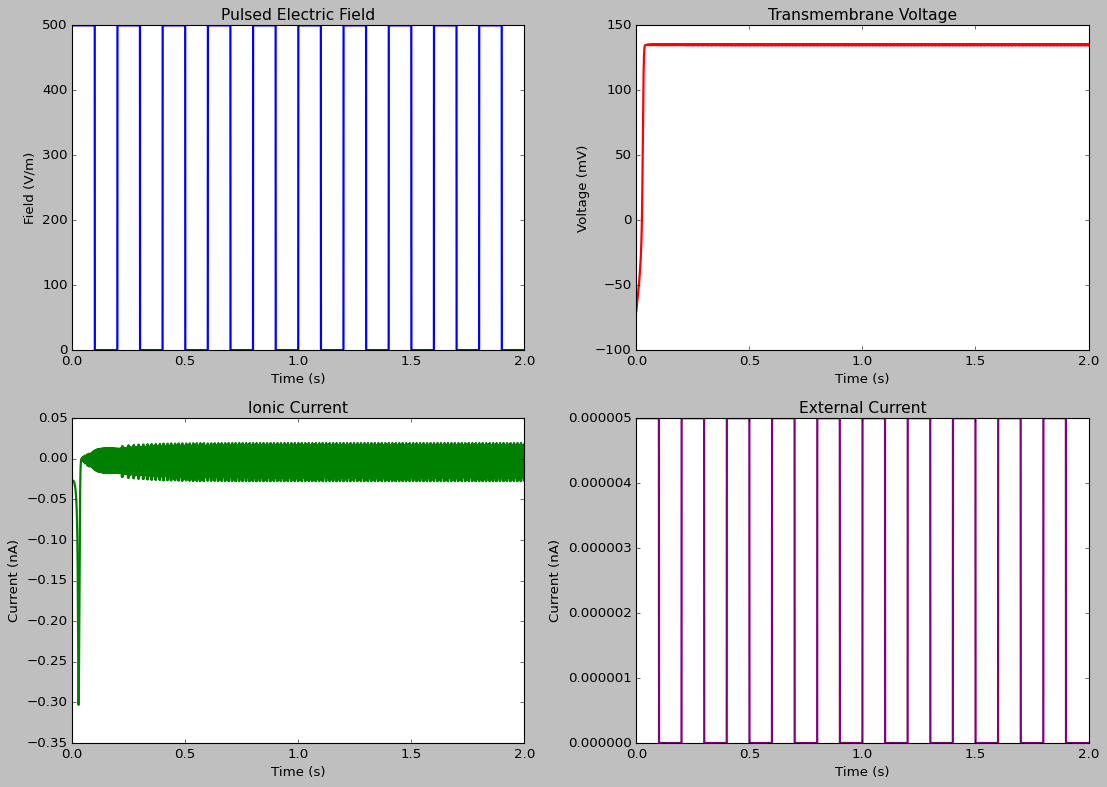

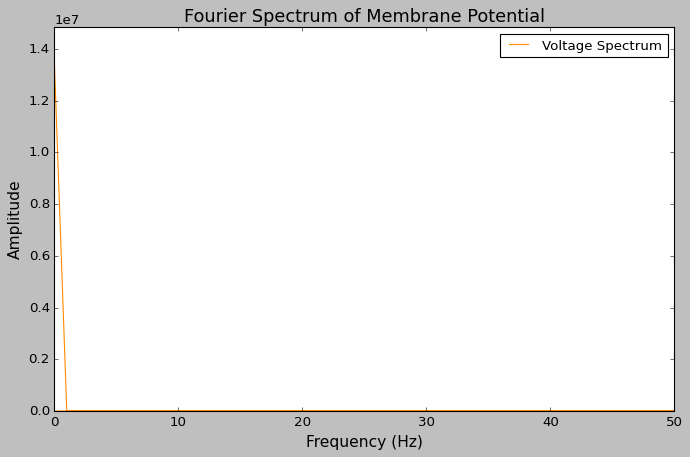

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

cell_side_length = 10e-6  # 10 micrometers side
surface_area = 6.0 * (cell_side_length ** 2)  # 6 sides * L^2
cell_volume = cell_side_length ** 3
relative_permittivity = 3
epsilon_0 = 8.85e-12  # permittivity of free space (F/m)
membrane_thickness = 1e-9  # 1 nm
capacitance = (relative_permittivity * epsilon_0 * surface_area) / membrane_thickness  # ~0.01 pF

single_channel_conductance = 20e-12  # 20 pS
channel_density = 10.0  # channels / µm^2
num_channels = channel_density * (surface_area * 1e12)  # area in µm^2
g_max = num_channels * single_channel_conductance  # total conductance

v_rev = 135.0  # mV
external_resistance = 1e12

# Pulsed external field parameters
pulse_frequency = 5.0  # Hz
pulse_period = 1.0 / pulse_frequency
pulse_width = 0.1  # seconds
field_amplitude = 500.0  # V/m
scale_factor = 5e3 # to normalize the dipole voltage (V_dipole) for better visualization

# Simulation parameters
simulation_time = 2.0  # seconds
time_step = 1e-5
simulation_time_array = np.arange(0, simulation_time, time_step)

def pulse_wave(time, period, width):
    mod_time = time % period
    return 1.0 if (mod_time < width) else 0.0

def alpha_m(voltage): return 8.5 / (1.0 + np.exp((voltage - 8.0) / -12.5))

def beta_m(voltage): return 35.0 / (1.0 + np.exp((voltage + 74.0) / 14.5))

def dynamics(time, variables):
    voltage, gating_variable = variables

    # Gating variable ODE
    alpha = alpha_m(voltage)
    beta = beta_m(voltage)
    gating_derivative = alpha * (1.0 - gating_variable) - beta * gating_variable

    # Ionic current
    ionic_current = g_max * gating_variable * ((voltage - v_rev) * 1e-3)

    # External field
    field_activation = field_amplitude * pulse_wave(time, pulse_period, pulse_width)
    i_p = field_activation * cell_side_length / external_resistance

    # Membrane potential derivative
    membrane_voltage_derivative = (-ionic_current + i_p) / capacitance
    return [membrane_voltage_derivative * 1e3, gating_derivative]

initial_voltage = -70.0  # Resting potential (mV)
initial_gating = alpha_m(initial_voltage) / (alpha_m(initial_voltage) + beta_m(initial_voltage))
initial_conditions = [initial_voltage, initial_gating]

solution = solve_ivp(dynamics, [0, simulation_time], initial_conditions, t_eval=simulation_time_array, method="RK45")

# Extract solutions
time_solution = solution.t
voltage_solution = solution.y[0]
gating_solution = solution.y[1]

# E-field array for plotting
field_array = np.array([field_amplitude * pulse_wave(tt, pulse_period, pulse_width) for tt in time_solution])
external_current_array = field_array * cell_side_length / external_resistance
ionic_current_array = g_max * gating_solution * ((voltage_solution - v_rev) * 1e-3)

plt.style.use("classic")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pulsed Electric Field
axes[0, 0].plot(time_solution, field_array, color="blue", linewidth=2)
axes[0, 0].set_title("Pulsed Electric Field", fontsize=14)
axes[0, 0].set_xlabel("Time (s)", fontsize=12)
axes[0, 0].set_ylabel("Field (V/m)", fontsize=12)

# Membrane Potential
axes[0, 1].plot(time_solution, voltage_solution, color="red", linewidth=2)
axes[0, 1].set_title("Transmembrane Voltage", fontsize=14)
axes[0, 1].set_xlabel("Time (s)", fontsize=12)
axes[0, 1].set_ylabel("Voltage (mV)", fontsize=12)

# Ionic Current
axes[1, 0].plot(time_solution, ionic_current_array * 1e9, color="green", linewidth=2)
axes[1, 0].set_title("Ionic Current", fontsize=14)
axes[1, 0].set_xlabel("Time (s)", fontsize=12)
axes[1, 0].set_ylabel("Current (nA)", fontsize=12)

# External Current
axes[1, 1].plot(time_solution, external_current_array * 1e9, color="purple", linewidth=2)
axes[1, 1].set_title("External Current", fontsize=14)
axes[1, 1].set_xlabel("Time (s)", fontsize=12)
axes[1, 1].set_ylabel("Current (nA)", fontsize=12)

plt.tight_layout()
plt.show()

steady_state_time = 1.0
steady_state_index = np.where(time_solution >= steady_state_time)[0][0]

voltage_fft = np.fft.fft(voltage_solution[steady_state_index:])
frequencies = np.fft.fftfreq(len(voltage_solution[steady_state_index:]), time_step)

plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(voltage_fft), label="Voltage Spectrum", color="darkorange")
plt.xlim(0, 50)
plt.ylim(0, max(np.abs(voltage_fft)) * 1.1)
plt.title("Fourier Spectrum of Membrane Potential", fontsize=16)
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.legend(fontsize=12)
plt.show()